In [1]:
import requests
from urllib.request import urlopen
from urllib.parse import urlencode,unquote,quote_plus
import urllib
import lxml
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re

In [2]:
# 법령 XML 상세조회 (시행기준. target=eflaw)

#기본 url
url_base = " http://www.law.go.kr/DRF/lawService.do"

#조회 url 세부 설정
user_id = 'bmsong' #open API ID (bmsong@kau.ac.kr의 아이디 부분)
target = "eflaw" #법령 조회시
MST = "218289" #ID 또는 MST #산업안전보건법 MST 218289
#ID = "001766" 
            #ID 산업안전보건법 법령ID 001766 (설명에는 ID로 조회하면 현행법령이 조회된다는데, 
            #target을 eflaw로 하면 ID로 요청해도, MST로 요청해도 같은 것 같다.
Type = "XML" #출력 형태 : HTML 또는 XML

url_sub = "?" +\
        "OC=" + user_id +\
        "&target=" + target +\
        "&MST=" + MST +\
        "&type=" + Type

#최종 url
url = url_base + url_sub

print(url)

response = requests.get(url)

#(1) response.text 사용하는 방법
#soup = BeautifulSoup(response.text.encode('utf-8'), 'lxml-xml') #lxml-xml -> lxml 추가 설치 필요(Beautifulsoup과 별도로 설치)

#(2) response.content 사용하는 방법
soup = BeautifulSoup(response.content, 'lxml-xml') #lxml-xml -> lxml 추가 설치 필요(Beautifulsoup과 별도로 설치)


# soup

 http://www.law.go.kr/DRF/lawService.do?OC=bmsong&target=eflaw&MST=218289&type=XML


In [3]:
lc_basic_df = pd.DataFrame() #DataFrame for Law Content 

data = soup.find('법령ID') #MST 정보
lc_basic_df['법령ID'] = [data.get_text()]

data = soup.find('법종구분') 
lc_basic_df['법종구분']= [data.get_text()]

data = soup.find('법령명_한글') 
lc_basic_df['법령명']= [data.get_text()]

data = soup.find('시행일자')
lc_basic_df['시행일자'] = [data.get_text()]

data = soup.find('공포일자') 
lc_basic_df['공포일자']= [data.get_text()]

data = soup.find('소관부처') 
lc_basic_df['소관부처']= [data.get_text()]

lc_basic_df

,법령ID,법종구분,법령명,시행일자,공포일자,소관부처
0,001766,법률,산업안전보건법,20210116,20200526,고용노동부


In [4]:
# data = soup.find_all('조문단위')
# df_info = pd.DataFrame()
# info = []
# for i in data:
#     detail = {}
#     detail["index"] = np.nan
#     detail["조문제목"] = np.nan
#     detail["조문내용"] = np.nan
#     detail["항문내용"] = np.nan
#     detail["호문내용"] = np.nan
#     if i.find("조문여부").get_text() == "조문":
#         조문제목 = i.find("조문내용").get_text().strip().split(")")[0]+")"
#         detail["조문제목"] = 조문제목
#         if i.find("조문내용"):
#             조문내용 = i.find("조문내용").get_text().strip()[len(조문제목):-1].strip()
#             detail["조문내용"] = 조문내용
        
#         df_info = df_info.append(detail,ignore_index = True)

#         if i.find("항내용"):
#             for j in i.find_all("항내용"):
#                 detail["항문내용"] = j.get_text().strip()
#                 df_info = df_info.append(detail,ignore_index = True)
#                 if i.find("호내용"):
#                     for k in i.find_all("호내용"):
#                         detail["호문내용"] = k.get_text().strip()
#                         df_info = df_info.append(detail,ignore_index = True)
#                 detail["호문내용"] = np.nan
# df_info = df_info[["조문제목","조문내용","항문내용","호문내용"]]
# df_info.head(30)

In [5]:
# data = soup.find_all('조문단위')
# df_info = pd.DataFrame()
# info = []
# for i in data:
#     detail = {}
#     detail["index"] = np.nan
#     detail["조문제목"] = np.nan
#     detail["조문내용"] = np.nan
#     detail["항문내용"] = np.nan
#     detail["호문내용"] = np.nan
#     if i.find("조문여부").get_text() == "조문":
#         조문제목 = i.find("조문내용").get_text().strip().split(")")[0]+")"
#         detail["조문제목"] = 조문제목
#         if i.find("조문내용"):
#             조문내용 = i.find("조문내용").get_text().strip()[len(조문제목):-1].strip()
#             detail["조문내용"] = 조문내용
        
#         df_info = df_info.append(detail,ignore_index = True)
        
#         if i.find("항"):
#             for j in i.find_all("항"):
#                 if j.find("항내용"):
#                     detail["항문내용"] = j.항내용.get_text().strip()
#                     df_info = df_info.append(detail,ignore_index = True)
#                 if j.find("호내용"):
#                     for k in j.find_all("호내용"):
#                         detail["호문내용"] = k.get_text().strip()
#                         df_info = df_info.append(detail,ignore_index = True)
#                 detail["호문내용"] = np.nan
# df_info = df_info[["조문제목","조문내용","항문내용","호문내용"]]
# df_info

In [6]:
data = soup.find_all('조문단위')
df_info = pd.DataFrame()
info = []
for i in data:
    info_str = ""
    if i.find("조문여부").get_text() == "조문":
        info_str += i.조문내용.get_text().strip()
        if i.항:
            hang_nums = i.find_all("항번호")
            ho_nums = i.find_all("호번호")
            for idx, p in enumerate(i.find_all("호내용")):
                info_str += p.get_text().split(ho_nums[idx].get_text())[1].strip()
            for hang_idx, k in enumerate(i.find_all("항내용")):
                info_str += k.get_text().strip().split(hang_nums[hang_idx].get_text())[1].strip()
                for ho_idx ,j in enumerate(i.find_all("호내용")):
                    info_str += j.get_text().strip().split(ho_nums[ho_idx].get_text())[1].strip()
        info.append(info_str)
df_info["조내용"] = info
df_info

,조내용
0,제1조(목적) 이 법은 산업 안전 및 보건에 관한 기준을 확립하고 그 책임의 소재를...
1,제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2020.5.2...
2,"제3조(적용 범위) 이 법은 모든 사업에 적용한다. 다만, 유해ㆍ위험의 정도, 사업..."
3,제4조(정부의 책무)산업 안전 및 보건 정책의 수립 및 집행산업재해 예방 지원 및 ...
4,제5조(사업주 등의 의무)이 법과 이 법에 따른 명령으로 정하는 산업재해 예방을 위...
...,...
172,제171조(벌칙) 다음 각 호의 어느 하나에 해당하는 자는 1천만원 이하의 벌금에 ...
173,제172조(벌칙) 제64조제1항 또는 제2항을 위반한 자는 500만원 이하의 벌금에...
174,"제173조(양벌규정) 법인의 대표자나 법인 또는 개인의 대리인, 사용인, 그 밖의 ..."
175,제174조(형벌과 수강명령 등의 병과)안전 및 보건에 관한 교육그 밖에 산업재해 예...


In [7]:
df_info.to_excel('산업안전보건법.xlsx',index = False)

# NLP(자연어 처리)



https://konlpy-ko.readthedocs.io/ko/v0.4.4/install/#id1

(konlpy를 사용하기위한 패키지를 다운받는 매뉴얼 입니다)


In [8]:
posts = df_info.get("조내용")
posts

0      제1조(목적) 이 법은 산업 안전 및 보건에 관한 기준을 확립하고 그 책임의 소재를...
1      제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2020.5.2...
2      제3조(적용 범위) 이 법은 모든 사업에 적용한다. 다만, 유해ㆍ위험의 정도, 사업...
3      제4조(정부의 책무)산업 안전 및 보건 정책의 수립 및 집행산업재해 예방 지원 및 ...
4      제5조(사업주 등의 의무)이 법과 이 법에 따른 명령으로 정하는 산업재해 예방을 위...
                             ...                        
172    제171조(벌칙) 다음 각 호의 어느 하나에 해당하는 자는 1천만원 이하의 벌금에 ...
173    제172조(벌칙) 제64조제1항 또는 제2항을 위반한 자는 500만원 이하의 벌금에...
174    제173조(양벌규정) 법인의 대표자나 법인 또는 개인의 대리인, 사용인, 그 밖의 ...
175    제174조(형벌과 수강명령 등의 병과)안전 및 보건에 관한 교육그 밖에 산업재해 예...
176    제175조(과태료)제119조제2항에 따라 기관석면조사를 하지 아니하고 건축물 또는 ...
Name: 조내용, Length: 177, dtype: object

In [9]:
from konlpy.tag import Mecab
tagger = Mecab()

In [10]:
# 불용어 리스트
# 불용어, 불필요 단어 제거
stop_words_df = pd.read_excel("stopwords.xlsx")
stop_words_df

,불용어
0,아
1,휴
2,아이구
3,아이쿠
4,아이고
...,...
674,영
675,조
676,항
677,등


In [11]:
# 명사부분 추출
nouns = []
for post in posts:
    for noun in tagger.nouns(post):
        if noun not in list(stop_words_df.get("불용어")):
            nouns.append(noun)
nouns[0:10]

['목적', '법', '산업', '안전', '보건', '기준', '확립', '책임', '소재', '산업']

In [12]:
words = []
for post in posts:
    words.extend(tagger.pos(post))
words[0:10]

[('제', 'XPN'),
 ('1', 'SN'),
 ('조', 'NNG'),
 ('(', 'SSO'),
 ('목적', 'NNG'),
 (')', 'SSC'),
 ('이', 'JKS'),
 ('법', 'NNG'),
 ('은', 'JX'),
 ('산업', 'NNG')]

In [13]:
# 동사 추출
verbs=[]
for word in words:
    if word[1]=='VV':
        verbs.append(word[0]+'다')
verbs[0:10]

['하다', '의하다', '인하다', '걸리다', '정하다', '하다', '맡기다', '받다', '받다', '받다']

In [14]:
# 형용사 추출
adjective=[]
for word in words:
    if word[1]=='VA':
        adjective.append(word[0]+'다')
adjective[0:10]

['같다', '심하다', '있다', '없다', '같다', '같다', '같다', '같다', '같다', '없다']

In [15]:
# 가장많이 나오는 명사 상위 20개
from collections import Counter
num_top_nouns = 20
nouns_counter = Counter(nouns)
top_nouns = dict(nouns_counter.most_common(num_top_nouns))
top_nouns
# print(len(counted_nouns))

{'조제': 1533,
 '안전': 1016,
 '경우': 907,
 '보건': 671,
 '고용': 571,
 '자제': 446,
 '물질': 420,
 '호': 398,
 '위반': 382,
 '근로자': 353,
 '해당': 353,
 '사항': 347,
 '작업': 342,
 '기관': 320,
 '노동': 302,
 '부령': 301,
 '장관': 262,
 '노동부': 261,
 '밖': 255,
 '자료': 255}

In [16]:
!pip install wordcloud

In [17]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", font_path='./font/NanumBarunGothic.ttf')
wc.generate_from_frequencies(top_nouns)

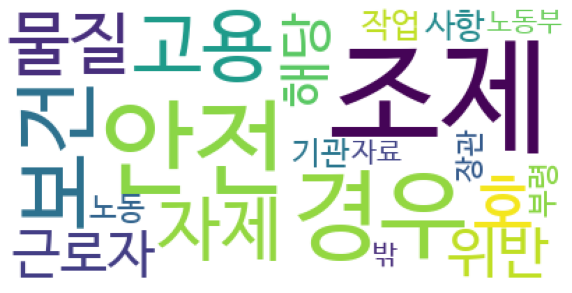

In [18]:
# 많이 나타나는 단어일수록 크게 나타남
import matplotlib.pyplot as plt
figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(wc)

# TfidfVectorizer

 TF(Term Frequency) : 특정 단어가 하나의 데이터 안에서 등장하는 횟수

DF(Document Frequency) : 특정 단어가 여러 데이터에 자주 등장하는지를 알려주는 지표.

IDF(Inverse Document Frequency) : DF에 역수를 취해(inverse) 구함

TF-IDF : TF와 IDF를 곱한 값. 즉 TF가 높고, DF가 낮을수록 값이 커지는 것을 이용하는 것입니다.

해당 단위(문장) 안에서는 많이 등장하지만, 다른 문서들까지 전체에서는 적게 사용될수록, 분별력 있는 특징이란 것입니다.

In [19]:
# 자주 등장한 명사 20 개 기준
from sklearn.feature_extraction.text import TfidfVectorizer
tfidv = TfidfVectorizer(sublinear_tf = True).fit(top_nouns)
tfidv.transform(posts).toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.76749457, ..., 0.        , 0.        ,
        0.45329466],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.62791376, 0.        , 0.        , ..., 0.        , 0.        ,
        0.77828292],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.45450839, ..., 0.        , 0.        ,
        0.61665743]])

In [20]:
# 아예 등장하지 않는다면 0,
# 그 이외에는 실수값이 크다면 그 단어가 보다 가치있는 특징이라는 것
# 작다면 그다지 가치가 없다고 판단이 가능
pd.DataFrame(tfidv.transform(posts).toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
1,0.000000,0.0,0.767495,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.453295,0.0,0.0,0.453295
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.634925,0.0,0.000000,0.772574,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
4,0.000000,0.0,0.386495,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.922291,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1.000000
173,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
174,0.627914,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.778283
175,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.498305,0.867002,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000


In [21]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(posts)
sorted(tfidf_vectorizer.vocabulary_.items())

[('100분의', 0),
 ('10시부터', 1),
 ('10억원', 2),
 ('1까지', 3),
 ('1년', 4),
 ('1년의', 5),
 ('1년이', 6),
 ('1억원', 7),
 ('1일', 8),
 ('1주', 9),
 ('1천500만원', 10),
 ('1천만원', 11),
 ('200시간의', 12),
 ('2020', 13),
 ('26', 14),
 ('2개', 15),
 ('2년', 16),
 ('2년으로', 17),
 ('2년을', 18),
 ('2년이', 19),
 ('2분의', 20),
 ('300만원', 21),
 ('30년', 22),
 ('31', 23),
 ('34시간을', 24),
 ('3년', 25),
 ('3년의', 26),
 ('3일', 27),
 ('3천만원', 28),
 ('500만원', 29),
 ('5년', 30),
 ('5년간', 31),
 ('5년마다', 32),
 ('5년으로', 33),
 ('5천만원', 34),
 ('60개월을', 35),
 ('6개월', 36),
 ('6시간', 37),
 ('6시까지', 38),
 ('6의', 39),
 ('7년', 40),
 ('fume', 41),
 ('mist', 42),
 ('ㆍ미스트', 43),
 ('ㆍ산소결핍ㆍ병원체', 44),
 ('ㆍ제2항', 45),
 ('ㆍ제2항을', 46),
 ('使用年限', 47),
 ('倂科', 48),
 ('共謀', 49),
 ('動力', 50),
 ('危害', 51),
 ('實刑', 52),
 ('敎唆', 53),
 ('疫學調査', 54),
 ('精密工作', 55),
 ('計上', 56),
 ('計測監視', 57),
 ('試料', 58),
 ('財源', 59),
 ('가공', 60),
 ('가능하지', 61),
 ('가능한', 62),
 ('가동해서는', 63),
 ('가맹본부', 64),
 ('가맹본부는', 65),
 ('가맹본부의', 66),
 ('가맹사업거래의', 67),
 ('가맹점사업자에게', 68),
 ('가맹

In [22]:
tfidfv = TfidfVectorizer().fit_transform(posts)
tfidfv.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.11042345, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [23]:
from konlpy.tag import Okt
okt = Okt()

oo = okt.pos(posts[0],
        norm=True,   # 정규화(normalization)
        stem=True    # 어간추출(stemming)
        )
print(oo)

[('제', 'Noun'), ('1조', 'Number'), ('(', 'Punctuation'), ('목적', 'Noun'), (')', 'Punctuation'), ('이', 'Noun'), ('법', 'Noun'), ('은', 'Josa'), ('산업', 'Noun'), ('안전', 'Noun'), ('및', 'Noun'), ('보건', 'Noun'), ('에', 'Josa'), ('관', 'Noun'), ('한', 'Josa'), ('기준', 'Noun'), ('을', 'Josa'), ('확립', 'Noun'), ('하고', 'Josa'), ('그', 'Noun'), ('책임', 'Noun'), ('의', 'Josa'), ('소재', 'Noun'), ('를', 'Josa'), ('명확하다', 'Adjective'), ('하다', 'Verb'), ('산업', 'Noun'), ('재해', 'Noun'), ('를', 'Josa'), ('예방', 'Noun'), ('하고', 'Josa'), ('쾌적하다', 'Adjective'), ('작업', 'Noun'), ('환경', 'Noun'), ('을', 'Josa'), ('조', 'Modifier'), ('성함', 'Noun'), ('으로써', 'Josa'), ('노무', 'Noun'), ('를', 'Josa'), ('제공', 'Noun'), ('하다', 'Verb'), ('사람', 'Noun'), ('의', 'Josa'), ('안전', 'Noun'), ('및', 'Noun'), ('보건', 'Noun'), ('을', 'Josa'), ('유지', 'Noun'), ('ㆍ', 'Foreign'), ('증진', 'Noun'), ('함', 'Noun'), ('을', 'Josa'), ('목적', 'Noun'), ('으로', 'Josa'), ('하다', 'Verb'), ('.', 'Punctuation'), ('<', 'Punctuation'), ('개정', 'Noun'), ('2020.5', 'Number'), ('.', '

In [51]:
def tokenizer(raw_texts, pos=["Noun","Alpha","Verb","Number"], stopword=list(stop_words_df.get("불용어"))):
    p = okt.pos(raw_texts, 
            norm=True,   # 정규화(normalization)
            stem=True    # 어간추출(stemming)
            )
    o = [word for word, tag in p if len(word) > 1 and tag in pos and word not in stopword]
    
    return(o)

tokenizer(posts[0])

['1조',
 '목적',
 '산업',
 '안전',
 '보건',
 '기준',
 '확립',
 '책임',
 '소재',
 '하다',
 '산업',
 '재해',
 '예방',
 '작업',
 '환경',
 '성함',
 '노무',
 '제공',
 '하다',
 '사람',
 '안전',
 '보건',
 '유지',
 '증진',
 '목적',
 '하다',
 '개정',
 '2020.5',
 '26']

In [25]:
def tokenizer_1(post):
    nouns = []
  
    for noun in tagger.nouns(post):
        if noun not in list(stop_words_df.get("불용어")):
            nouns.append(noun)
    return nouns

tokenizer_1(posts[0])

['목적',
 '법',
 '산업',
 '안전',
 '보건',
 '기준',
 '확립',
 '책임',
 '소재',
 '산업',
 '재해',
 '예방',
 '작업',
 '환경',
 '조성',
 '노무',
 '제공',
 '사람',
 '안전',
 '보건',
 '유지',
 '목적',
 '개정']

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorize = TfidfVectorizer(
    tokenizer=tokenizer_1, # 문장에 대한 tokenizer (위에 정의한 함수 이용)
    min_df=1,            # 단어가 출현하는 최소 문서의 개수
    sublinear_tf=True    # tf값에 1+log(tf)를 적용하여 tf값이 무한정 커지는 것을 막음
)

X = vectorize.fit_transform(posts)
X.toarray() 

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.0930232, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
# 2번째와 3번째 문서(코사인 값)
print(euclidean_distances(X[1], X[2]))#, X)
#[[1.27771711]]
print(cosine_similarity(X[1], X[2]))#, X)
# [[0.1837195]]

[[1.23297665]]
[[0.23988429]]


# Euclidean Distance(Tfid)

In [28]:
# 모든 조에 해당하는 euclidean distance 를 계산
euclidean_result = []
for x in range(len(df_info)):
    tmp = []
    for y in range(len(df_info)):
        tmp.append(euclidean_distances(X[x], X[y])[0][0])
    euclidean_result.append(tmp)
# euclidean_result

In [29]:
# 모든 조에 해당하는 euclidean distance 결과 값을
# DataFrame 형태로 변환
euclidean_result_df = pd.DataFrame(euclidean_result)
euclidean_result_df

,0,1,2,3,4,5,6,7,8,9,...,167,168,169,170,171,172,173,174,175,176
0,0.000000,1.259077,1.380300,1.175954,1.207450,1.299996,1.395277,1.391412,1.325640,1.354788,...,1.387709,1.394951,1.382467,1.378686,1.403650,1.382888,1.414214,1.414214,1.345704,1.335961
1,1.259077,0.000000,1.232977,1.323393,1.234417,1.295661,1.343151,1.364321,1.362879,1.282708,...,1.363633,1.385649,1.358414,1.351121,1.396168,1.374891,1.410197,1.388977,1.366394,1.254809
2,1.380300,1.232977,0.000000,1.386150,1.321410,1.321398,1.411250,1.361631,1.401724,1.356803,...,1.394348,1.391972,1.401302,1.405036,1.400536,1.403763,1.399899,1.405997,1.386696,1.351400
3,1.175954,1.323393,1.386150,0.000000,1.283775,1.230475,1.348417,1.327168,1.304528,1.372317,...,1.404011,1.401895,1.371271,1.377949,1.369723,1.355327,1.409478,1.410738,1.296508,1.333559
4,1.207450,1.234417,1.321410,1.283775,0.000000,1.181976,1.378598,1.319656,1.318426,1.335533,...,1.381657,1.354524,1.365782,1.355865,1.357823,1.351476,1.405250,1.397359,1.322487,1.286314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,1.382888,1.374891,1.403763,1.355327,1.351476,1.347880,1.380377,1.394994,1.414214,1.368323,...,1.171075,0.782730,0.969826,1.059851,1.234070,0.000000,1.027052,1.291125,1.302721,1.187286
173,1.414214,1.410197,1.399899,1.409478,1.405250,1.414214,1.404740,1.406648,1.414214,1.398976,...,1.175454,1.055020,1.195628,1.225557,1.131651,1.027052,0.000000,1.282339,1.356921,1.325671
174,1.414214,1.388977,1.405997,1.410738,1.397359,1.414214,1.405899,1.404291,1.412335,1.402678,...,1.330394,1.299846,1.314731,1.348947,1.328527,1.291125,1.282339,0.000000,1.366801,1.357897
175,1.345704,1.366394,1.386696,1.296508,1.322487,1.318072,1.366674,1.344664,1.352740,1.352354,...,1.189568,1.257582,1.300692,1.335143,1.015599,1.302721,1.356921,1.366801,0.000000,1.321686


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


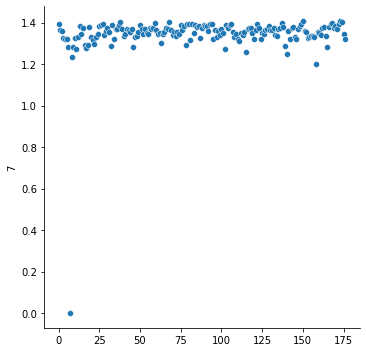

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
x = [i for i in range(len(df_info))]
jo = 8
y_euclidean = euclidean_result_df.get(jo-1)
# y = euclidean_result_df.loc[2]

# 2조와 다른 조들 간의euclidean distance 분포 시각화
sns.relplot(x,y_euclidean)
plt.show()


In [31]:
# euclidean distance 값으로 
# 8조와 가장 비슷한 조를 찾기위한 과정
y_euclidean = euclidean_result_df[jo-1]
dic = {}
for i in range(len(y_euclidean)):
    dic[i+1] = y_euclidean[i]
#8조와 비슷한 조 찾기 위함
# euclidean distance 를 dic에 씌워 sorting 함(1부터 10위까지)
sorted(dic.items(), key=lambda x: x[1])[0:10]

[(8, 0.0),
 (159, 1.1997133735244712),
 (9, 1.2339850988129575),
 (141, 1.249947655342399),
 (116, 1.2588586239691422),
 (12, 1.273380477935094),
 (103, 1.2751912213923933),
 (18, 1.2765253746607559),
 (47, 1.2834221022776653),
 (7, 1.2834973950279238)]

# Cosine Similarity(Tfid)

In [32]:
cosine_result = []
for x in range(len(df_info)):
    tmp = []
    for y in range(len(df_info)):
        tmp.append(cosine_similarity(X[x], X[y])[0][0])
    cosine_result.append(tmp)

In [33]:
# 모든 조에 해당하는 cosine similarity 결과 값을
# DataFrame 형태로 변환
cosine_result_df = pd.DataFrame(cosine_result)
cosine_result_df

,0,1,2,3,4,5,6,7,8,9,...,167,168,169,170,171,172,173,174,175,176
0,1.000000,0.207363,0.047386,0.308566,0.271032,0.155005,0.026601,0.031986,0.121339,0.082275,...,0.037132,0.027056,0.044392,0.049613,0.014884,0.043810,0.000000,0.000000,0.094540,0.107604
1,0.207363,1.000000,0.239884,0.124315,0.238108,0.160632,0.097973,0.069314,0.071280,0.177330,...,0.070253,0.039989,0.077356,0.087236,0.025357,0.054837,0.005673,0.035371,0.066484,0.212727
2,0.047386,0.239884,1.000000,0.039294,0.126938,0.126954,0.004187,0.072981,0.017585,0.079543,...,0.027897,0.031208,0.018176,0.012937,0.019249,0.014725,0.020142,0.011586,0.038537,0.086859
3,0.308566,0.124315,0.039294,1.000000,0.175960,0.242965,0.090886,0.119313,0.149103,0.058373,...,0.014376,0.017345,0.059808,0.050628,0.061930,0.081545,0.006685,0.004910,0.159533,0.110810
4,0.271032,0.238108,0.126938,0.175960,1.000000,0.301467,0.049733,0.129254,0.130876,0.108176,...,0.045512,0.082632,0.067320,0.080815,0.078158,0.086757,0.012637,0.023693,0.125514,0.172699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.043810,0.054837,0.014725,0.081545,0.086757,0.091610,0.047279,0.026996,0.000000,0.063847,...,0.314292,0.693667,0.529719,0.438358,0.238535,1.000000,0.472582,0.166499,0.151459,0.295176
173,0.000000,0.005673,0.020142,0.006685,0.012637,0.000000,0.013353,0.010670,0.000000,0.021432,...,0.309154,0.443466,0.285237,0.249005,0.359683,0.472582,1.000000,0.177803,0.079383,0.121298
174,0.000000,0.035371,0.011586,0.004910,0.023693,0.000000,0.011724,0.013984,0.002655,0.016248,...,0.115026,0.155200,0.135742,0.090170,0.117508,0.166499,0.177803,1.000000,0.065928,0.078058
175,0.094540,0.066484,0.038537,0.159533,0.125514,0.131343,0.066100,0.095939,0.085048,0.085569,...,0.292464,0.209244,0.154100,0.108697,0.484279,0.151459,0.079383,0.065928,1.000000,0.126572


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


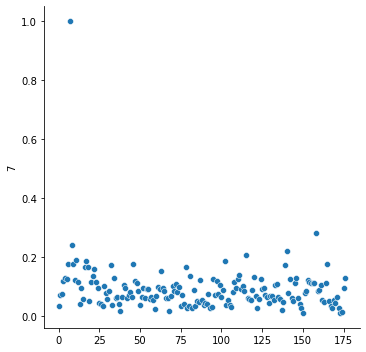

In [34]:
x = [i for i in range(len(df_info))]
y_cosine = cosine_result_df[jo-1]
# y = euclidean_result_df.loc[2]

# 8조와 다른 조들 간의 cosine simiarity 분포 시각화
sns.relplot(x,y_cosine)
plt.show()

In [35]:
# cosine similarity 값으로 
# 8조와 가장 비슷한 조를 찾기위한 과정
y_cosine = cosine_result_df[jo-1]
dic ={}
for i in range(len(y_cosine)):
    dic[i+1] = y_cosine[i]
#8조와 비슷한 조 찾기 위함
# euclidean distance 를 dic에 씌워 sorting 함(1부터 10위까지)
sorted(dic.items(), key=lambda x: x[1], reverse = True)[0:10]

# euclidean distance 를 이용한 값과 일치한 값이 도출됨
# [(8, 0.0),
#  (7, 1.24014661136316),
#  (141, 1.2404008803838469),
#  (12, 1.242192005734461),
#  (9, 1.248024204789678),
#  (159, 1.2549777162393492),
#  (10, 1.2556130803061363),
#  (18, 1.2615386170299787),
#  (17, 1.2726151189310564),
#  (103, 1.286027722244149)]

[(8, 1.0000000000000002),
 (159, 0.28034391069326636),
 (9, 0.23864038795378767),
 (141, 0.2188154294520196),
 (116, 0.2076374824292591),
 (12, 0.18925107920689624),
 (103, 0.18694367444188806),
 (18, 0.18524148392360829),
 (47, 0.1764138536925889),
 (7, 0.1763172184782668)]

# CountVectorizer(Tfid)
가장 단순한 특징으로, 텍스트에서 단위별 등장횟수를 카운팅하여 수치벡터화 하는 것

단위는 문서 단위, 문장 단위, 단어 단위... 가 될 수 있음

가장 많이 사용되는 것은 단어단위의 카운팅

In [36]:
# 빈도높은 상위 20개 명사들로 CountVectorizing
from sklearn.feature_extraction.text import CountVectorizer
countv = CountVectorizer().fit(top_nouns)
countv.transform(posts).toarray()
top_nouns

{'조제': 1533,
 '안전': 1016,
 '경우': 907,
 '보건': 671,
 '고용': 571,
 '자제': 446,
 '물질': 420,
 '호': 398,
 '위반': 382,
 '근로자': 353,
 '해당': 353,
 '사항': 347,
 '작업': 342,
 '기관': 320,
 '노동': 302,
 '부령': 301,
 '장관': 262,
 '노동부': 261,
 '밖': 255,
 '자료': 255}

In [37]:
pd.DataFrame(countv.transform(posts).toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0
1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,9,0,0,18,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
173,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
174,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
175,0,0,0,0,0,0,0,0,0,2,7,0,0,0,0,0,0,0


In [38]:
from sklearn.feature_extraction.text import CountVectorizer
countv = CountVectorizer(stop_words = list(stop_words_df.get("불용어")))
sp_mat = countv.fit_transform(posts)
# 희소행렬을 np array로
sp_mat.toarray()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['가서', '같은', '것과', '결과에', '결론을', '관계가', '관련이', '그런', '그럼에도', '그렇게', '그에', '그치지', '김에', '까닭에', '낫다', '년도', '논하지', '누가', '다시', '달려', '대로', '대해', '되는', '되다', '되어', '들면', '들자면', '듯하다', '따르는', '따름이다', '따지지', '때가', '만은', '만이', '많은', '말하면', '말할것도', '몰라도', '몰랏다', '못하다', '못하다하기보다는', '미치다', '바꾸어서', '바꿔', '밖에', '방면으로', '보면', '보아', '부류의', '비길수', '비추어', '뿐만', '사람들', '상대적으로', '생각이다', '서술한바와같이', '쓰여', '아니다', '아니라', '안다', '안된다', '않고', '않기', '않는다면', '않다', '않다면', '않도록', '않으면', '알겠는가', '어쩔수', '없고', '없다', '예를', '외에', '요만한', '우에', '위에서', '이렇게', '이로', '이르다', '이와', '이유는', '인하여', '임에', '점에서', '정도에', '정도의', '종합한것과같이', '주저하지', '줄은', '지경이다', '틀림없다', '편이', '하고', '하기', '하기만', '하는', '하는것만', '하는것이', '하다', '하면', '하지', '한하다', '할수록', '함으로써', '해도', '해서는', '형식으로', '힘이'] not in stop_words.
  warnings.warn('Your stop_words may

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [39]:
# 단어: 정수인덱스로 구성된 딕셔너리
countv.vocabulary_

{'제1조': 2896,
 '목적': 913,
 '법은': 1047,
 '산업': 1373,
 '안전': 1766,
 '보건에': 1092,
 '기준을': 652,
 '확립하고': 3878,
 '책임의': 3525,
 '소재를': 1562,
 '명확하게': 908,
 '하여': 3743,
 '산업재해를': 1392,
 '예방하고': 2001,
 '쾌적한': 3608,
 '작업환경을': 2538,
 '조성함으로써': 3263,
 '노무를': 693,
 '제공하는': 3187,
 '사람의': 1234,
 '보건을': 1093,
 '유지ㆍ증진함을': 2125,
 '목적으로': 917,
 '한다': 3750,
 '개정': 110,
 '2020': 13,
 '26': 14,
 '제2조': 2932,
 '정의': 2680,
 '법에서': 1046,
 '사용하는': 1311,
 '용어의': 2051,
 '뜻은': 860,
 '다음과': 718,
 '산업재해': 1390,
 '사람이': 1235,
 '업무에': 1908,
 '관계되는': 439,
 '건설물ㆍ설비ㆍ원재료ㆍ가스ㆍ증기ㆍ분진': 183,
 '등에': 841,
 '의하거나': 2205,
 '작업': 2496,
 '또는': 859,
 '밖의': 953,
 '업무로': 1896,
 '인하여': 2293,
 '사망': 1248,
 '부상하거나': 1177,
 '질병에': 3472,
 '걸리는': 204,
 '것을': 231,
 '말한다': 868,
 '중대재해': 3333,
 '재해': 2580,
 '정도가': 2662,
 '심하거나': 1747,
 '다수의': 716,
 '재해자가': 2586,
 '발생한': 984,
 '경우로서': 282,
 '고용노동부령으로': 370,
 '정하는': 2687,
 '재해를': 2583,
 '근로자': 557,
 '근로기준법': 552,
 '제2조제1항제1호에': 2934,
 '따른': 850,
 '근로자를': 570,
 '사업주': 1283,
 '사용하여': 1313,
 '사업을':

In [40]:
pd.DataFrame(countv.transform(posts).toarray())

,0,1,2,3,4,5,6,7,8,9,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
173,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
vectorize = CountVectorizer(
    tokenizer=tokenizer, # 문장에 대한 tokenizer (위에 정의한 함수 이용)
    min_df=1,            # 단어가 출현하는 최소 문서의 개수
)

X = vectorize.fit_transform(posts)
X.toarray() 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [8, 0, 0, ..., 0, 0, 0]])

In [42]:
# 2번째와 3번째 문서(코사인 값)
print(euclidean_distances(X[1], X[2]))#, X)

print(cosine_similarity(X[1], X[2]))#, X)

[[35.39774004]]
[[0.6084046]]


# Euclidean Distance(CountVectorizer)

In [43]:
# 모든 조에 해당하는 euclidean distance 를 계산
euclidean_result = []
for x in range(len(df_info)):
    tmp = []
    for y in range(len(df_info)):
        tmp.append(euclidean_distances(X[x], X[y])[0][0])
    euclidean_result.append(tmp)
# euclidean_result

In [44]:
# 모든 조에 해당하는 euclidean distance 결과 값을
# DataFrame 형태로 변환
euclidean_result_df = pd.DataFrame(euclidean_result)
euclidean_result_df

,0,1,2,3,4,5,6,7,8,9,...,167,168,169,170,171,172,173,174,175,176
0,0.000000,37.775654,10.099505,42.567593,35.860842,7.483315,9.848858,58.974571,12.000000,23.769729,...,12.409674,23.494680,23.043437,24.083189,12.000000,11.445523,6.782330,13.784049,45.628938,1021.858111
1,37.775654,0.000000,35.397740,52.430907,29.478806,36.728735,36.359318,51.951901,36.290495,27.239677,...,33.541020,32.664966,36.715120,31.000000,39.560081,35.327043,39.786933,34.856850,41.121770,998.776752
2,10.099505,35.397740,0.000000,46.151923,34.785054,9.899495,12.041595,57.253821,14.560220,22.427661,...,11.916375,21.863211,22.912878,22.759613,13.190906,11.618950,9.486833,13.416408,45.409250,1019.889210
3,42.567593,52.430907,46.151923,0.000000,48.187135,43.954522,43.324358,65.467549,41.036569,44.485953,...,46.065171,48.969378,46.743984,47.937459,46.518813,45.727453,46.303348,46.454279,49.779514,1012.551233
4,35.860842,29.478806,34.785054,48.187135,0.000000,34.292856,35.028560,50.000000,33.941125,29.647934,...,33.346664,33.256578,35.000000,31.749016,37.121422,33.867388,38.157568,34.322005,40.249224,1000.876616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,11.445523,35.327043,11.618950,45.727453,33.867388,10.816654,12.806248,56.929781,15.132746,22.226111,...,10.344080,18.947295,20.297783,18.627936,13.601471,0.000000,10.816654,12.288206,43.278170,1015.272870
173,6.782330,39.786933,9.486833,46.303348,38.157568,7.483315,10.535654,60.497934,13.711309,25.514702,...,12.409674,24.041631,23.430749,24.859606,10.295630,10.816654,0.000000,13.416408,48.062459,1023.596600
174,13.784049,34.856850,13.416408,46.454279,34.322005,13.266499,14.594520,56.213877,16.673332,22.693611,...,12.806248,20.445048,21.840330,21.071308,15.362291,12.288206,13.416408,0.000000,43.680659,1016.442817
175,45.628938,41.121770,45.409250,49.779514,40.249224,44.833024,44.260592,56.480085,42.988371,38.223030,...,41.400483,37.735925,42.320208,38.729833,44.766059,43.278170,48.062459,43.680659,0.000000,995.227612


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


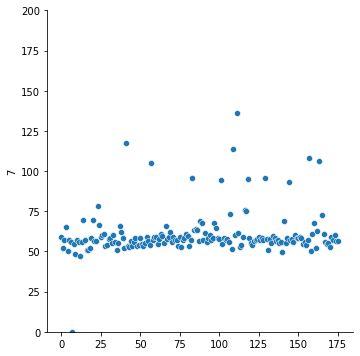

In [45]:
x = [i for i in range(len(df_info))]
jo = 8
y_euclidean = euclidean_result_df[jo-1]
# y = euclidean_result_df.loc[2]

# 8조와 다른 조들 간의euclidean distance 분포 시각화
sns.relplot(x,y_euclidean)
plt.ylim(0, 200)
plt.show()

In [46]:
# euclidean distance 값으로 
# 8조와 가장 비슷한 조를 찾기위한 과정
y_euclidean = euclidean_result_df[jo-1]
dic = {}
for i in range(len(y_euclidean)):
    dic[i+1] = y_euclidean[i]
#8조와 비슷한 조 찾기 위함
# euclidean distance 를 dic에 씌워 sorting 함(1부터 10위까지)
sorted(dic.items(), key=lambda x: x[1])[0:10]

[(8, 0.0),
 (13, 46.97871858618538),
 (10, 48.40454524112379),
 (141, 49.52776998815917),
 (5, 50.0),
 (159, 50.428166732491874),
 (18, 50.67543783727971),
 (132, 50.813384063650005),
 (17, 51.12729212465687),
 (36, 51.16639522186413)]

# Cosine Similarity(CountVectorizer)

In [47]:
cosine_result = []
for x in range(len(df_info)):
    tmp = []
    for y in range(len(df_info)):
        tmp.append(cosine_similarity(X[x], X[y])[0][0])
    cosine_result.append(tmp)

In [48]:
# 모든 조에 해당하는 cosine similarity 결과 값을
# DataFrame 형태로 변환
cosine_result_df = pd.DataFrame(cosine_result)
cosine_result_df

,0,1,2,3,4,5,6,7,8,9,...,167,168,169,170,171,172,173,174,175,176
0,1.000000,0.478534,0.281628,0.637004,0.518541,0.431821,0.417883,0.362302,0.496548,0.477439,...,0.387541,0.337119,0.279581,0.399730,0.099544,0.335101,0.152499,0.290423,0.516972,0.426106
1,0.478534,1.000000,0.608405,0.278240,0.724317,0.573047,0.499629,0.539243,0.457685,0.746204,...,0.638988,0.590901,0.445779,0.642894,0.216582,0.553382,0.263555,0.543750,0.587853,0.650603
2,0.281628,0.608405,1.000000,0.134754,0.518009,0.359692,0.300532,0.455559,0.274678,0.544491,...,0.506122,0.486603,0.312068,0.494357,0.172211,0.433555,0.239395,0.419728,0.423693,0.490542
3,0.637004,0.278240,0.134754,1.000000,0.372170,0.406464,0.398770,0.281524,0.517245,0.355138,...,0.172200,0.163565,0.245818,0.220775,0.108423,0.187434,0.078949,0.151872,0.452994,0.281312
4,0.518541,0.724317,0.518009,0.372170,1.000000,0.670377,0.477079,0.576542,0.508849,0.646170,...,0.552585,0.528042,0.460457,0.581880,0.293058,0.544276,0.257599,0.481494,0.596994,0.623862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.335101,0.553382,0.433555,0.187434,0.544276,0.444446,0.351382,0.432043,0.311881,0.535651,...,0.669600,0.679392,0.535264,0.759074,0.275839,1.000000,0.450749,0.566320,0.552180,0.793408
173,0.152499,0.263555,0.239395,0.078949,0.257599,0.179787,0.157485,0.202077,0.144715,0.279988,...,0.423547,0.334945,0.250000,0.411170,0.279751,0.450749,1.000000,0.352673,0.232849,0.347441
174,0.290423,0.543750,0.419728,0.151872,0.481494,0.380435,0.333244,0.442627,0.290911,0.500902,...,0.569376,0.569840,0.440841,0.584565,0.263095,0.566320,0.352673,1.000000,0.479675,0.582444
175,0.516972,0.587853,0.423693,0.452994,0.596994,0.573464,0.506698,0.488788,0.529238,0.625192,...,0.640364,0.645772,0.493949,0.610611,0.459811,0.552180,0.232849,0.479675,1.000000,0.619273


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


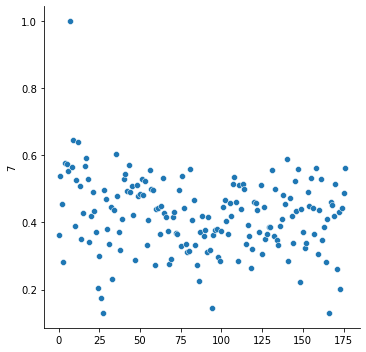

In [49]:
x = [i for i in range(len(df_info))]
y_cosine = cosine_result_df[jo-1]
# y = euclidean_result_df.loc[2]

# 2조와 다른 조들 간의 cosine simiarity 분포 시각화
sns.relplot(x,y_cosine)
plt.show()

In [50]:
# cosine similarity 값으로 
# 8조와 가장 비슷한 조를 찾기위한 과정
y_cosine = cosine_result_df[jo-1]
dic ={}
for i in range(len(y_cosine)):
    dic[i+1] = y_cosine[i]
#8조와 비슷한 조 찾기 위함
# euclidean distance 를 dic에 씌워 sorting 함(1부터 10위까지)
sorted(dic.items(), key=lambda x: x[1], reverse = True)[0:10]

# euclidean distance 를 이용한 값과 약간 상이한 도출됨
# [(8, 0.0),
#  (13, 47.148700936505136),
#  (10, 48.41487374764082),
#  (141, 49.54795656734998),
#  (5, 50.0199960015992),
#  (159, 50.44799302251776),
#  (18, 50.695167422546305),
#  (132, 50.84289527554464),
#  (17, 51.146847410177685),
#  (36, 51.18593556827891)]

[(8, 1.0000000000000002),
 (10, 0.6468377270541565),
 (13, 0.6393938355230333),
 (36, 0.6038909585540355),
 (18, 0.5934932569168925),
 (141, 0.5877372407551639),
 (5, 0.5765419791934745),
 (6, 0.5744190900650121),
 (44, 0.5713211369794873),
 (17, 0.5686209642746199)]